# CycleGAN implementation - I'm Something of a Painter Myself

This notebook implements a **CycleGAN** with:
- **ResNet-9 Generator** (9 residual blocks)
- **70x70 PatchGAN Discriminator**
- **256x256 resolution** (competition requirement)
- **Cycle consistency + Identity + Adversarial losses**


Author: 
- Azmi Abidi

## 1. Setup & Installation

In [1]:
!pip install -q torchmetrics[image] torch-fidelity

In [2]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from datetime import datetime
import csv
import zipfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [3]:
# Configuration
class Config:
    # Paths
    MONET_DIR = '/kaggle/input/gan-getting-started/monet_jpg'
    PHOTO_DIR = '/kaggle/input/gan-getting-started/photo_jpg'
    OUTPUT_DIR = '/kaggle/working'
    
    # Image settings
    IMAGE_SIZE = 256 
    CHANNELS = 3
    
    # Training settings
    EPOCHS = 25
    BATCH_SIZE = 1
    LR = 2e-4
    BETA1 = 0.5
    BETA2 = 0.999
    
    # Loss weights
    LAMBDA_CYCLE = 10.0  
    LAMBDA_IDENTITY = 5.0 
    
    # Architecture
    NGF = 64  # Generator filters
    NDF = 64  # Discriminator filters
    N_RESIDUAL = 9  # ResNet blocks (9 for 256x256)
    
    # Generation
    NUM_GENERATE = 7000
    
    # Misc
    SEED = 433
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_WORKERS = 2

cfg = Config()

# Set seeds
random.seed(cfg.SEED)
np.random.seed(cfg.SEED)
torch.manual_seed(cfg.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.SEED)

# Directories
os.makedirs(os.path.join(cfg.OUTPUT_DIR, 'samples'), exist_ok=True)
os.makedirs(os.path.join(cfg.OUTPUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(cfg.OUTPUT_DIR, 'images'), exist_ok=True)

## 2. Dataset

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Loaded {len(self.images)} images from {root_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
# Transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize(int(cfg.IMAGE_SIZE * 1.12), transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(cfg.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
monet_dataset = ImageDataset(cfg.MONET_DIR, transform=train_transform)
photo_dataset = ImageDataset(cfg.PHOTO_DIR, transform=train_transform)

monet_loader = DataLoader(monet_dataset, batch_size=cfg.BATCH_SIZE, 
                          shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True)
photo_loader = DataLoader(photo_dataset, batch_size=cfg.BATCH_SIZE, 
                          shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True)

Loaded 300 images from /kaggle/input/gan-getting-started/monet_jpg
Loaded 7038 images from /kaggle/input/gan-getting-started/photo_jpg


## 3. CycleGAN Architecture

### Generator: ResNet-9
- Encoder: 2 downsampling layers
- Transformer: 9 residual blocks
- Decoder: 2 upsampling layers

### Discriminator: 70x70 PatchGAN
- Classifies 70x70 overlapping patches as real/fake

In [6]:
class ResidualBlock(nn.Module):
    """Residual block with instance normalization."""
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [7]:
class Generator(nn.Module):
    """ResNet-9 Generator for CycleGAN."""
    def __init__(self, in_channels=3, out_channels=3, ngf=64, n_residual=9):
        super().__init__()
        
        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, ngf, 7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = ngf
        out_features = ngf * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual):
            model += [ResidualBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, out_channels, 7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class Discriminator(nn.Module):
    """70x70 PatchGAN Discriminator."""
    def __init__(self, in_channels=3, ndf=64):
        super().__init__()
        
        self.model = nn.Sequential(
            # Layer 1: No normalization
            nn.Conv2d(in_channels, ndf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=1, padding=1),
            nn.InstanceNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer
            nn.Conv2d(ndf * 8, 1, 4, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
# Initialize models
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('InstanceNorm') != -1:
        if m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

# Create generators and discriminators
G_monet = Generator(ngf=cfg.NGF, n_residual=cfg.N_RESIDUAL).to(cfg.DEVICE)  
G_photo = Generator(ngf=cfg.NGF, n_residual=cfg.N_RESIDUAL).to(cfg.DEVICE)  
D_monet = Discriminator(ndf=cfg.NDF).to(cfg.DEVICE)  
D_photo = Discriminator(ndf=cfg.NDF).to(cfg.DEVICE)

# Initialize weights
G_monet.apply(init_weights)
G_photo.apply(init_weights)
D_monet.apply(init_weights)
D_photo.apply(init_weights)

# Count parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Generator params: {count_params(G_monet):,}")
print(f"Discriminator params: {count_params(D_monet):,}")
print(f"Total params: {count_params(G_monet) * 2 + count_params(D_monet) * 2:,}")

Generator params: 11,378,179
Discriminator params: 2,764,737
Total params: 28,285,832


## 4. Loss Functions & Optimizers

In [10]:
# Loss functions
criterion_GAN = nn.MSELoss()  # LSGAN
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(
    itertools.chain(G_monet.parameters(), G_photo.parameters()),
    lr=cfg.LR, betas=(cfg.BETA1, cfg.BETA2)
)
optimizer_D_monet = optim.Adam(D_monet.parameters(), lr=cfg.LR, betas=(cfg.BETA1, cfg.BETA2))
optimizer_D_photo = optim.Adam(D_photo.parameters(), lr=cfg.LR, betas=(cfg.BETA1, cfg.BETA2))

# Learning rate schedulers (linear decay after half epochs)
def lambda_rule(epoch):
    return 1.0 - max(0, epoch - cfg.EPOCHS // 2) / (cfg.EPOCHS // 2 + 1)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_monet = optim.lr_scheduler.LambdaLR(optimizer_D_monet, lr_lambda=lambda_rule)
scheduler_D_photo = optim.lr_scheduler.LambdaLR(optimizer_D_photo, lr_lambda=lambda_rule)

In [11]:
class ReplayBuffer:
    """Buffer to store previously generated images for discriminator training."""
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        result = []
        for element in data:
            element = element.unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.max_size - 1)
                    result.append(self.data[idx].clone())
                    self.data[idx] = element
                else:
                    result.append(element)
        return torch.cat(result, 0)

fake_monet_buffer = ReplayBuffer()
fake_photo_buffer = ReplayBuffer()

## 5. Training Loop

In [12]:
def train_epoch(epoch):
    G_monet.train()
    G_photo.train()
    D_monet.train()
    D_photo.train()
    
    losses = {'G': [], 'D_monet': [], 'D_photo': [], 'cycle': [], 'identity': []}
    
    monet_iter = iter(monet_loader)
    photo_iter = iter(photo_loader)
    
    n_batches = min(len(monet_loader), len(photo_loader))
    pbar = tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{cfg.EPOCHS}")
    
    for i in pbar:
        try:
            real_monet = next(monet_iter).to(cfg.DEVICE)
        except StopIteration:
            monet_iter = iter(monet_loader)
            real_monet = next(monet_iter).to(cfg.DEVICE)
        
        try:
            real_photo = next(photo_iter).to(cfg.DEVICE)
        except StopIteration:
            photo_iter = iter(photo_loader)
            real_photo = next(photo_iter).to(cfg.DEVICE)
        
        # Target tensors
        valid = torch.ones((real_monet.size(0), 1, 30, 30), device=cfg.DEVICE)
        fake = torch.zeros((real_monet.size(0), 1, 30, 30), device=cfg.DEVICE)
        
        # Train Generators 
        optimizer_G.zero_grad()
        
        # Identity loss
        same_monet = G_monet(real_monet)
        loss_identity_monet = criterion_identity(same_monet, real_monet) * cfg.LAMBDA_IDENTITY
        
        same_photo = G_photo(real_photo)
        loss_identity_photo = criterion_identity(same_photo, real_photo) * cfg.LAMBDA_IDENTITY
        
        # GAN loss
        fake_monet = G_monet(real_photo)
        pred_fake_monet = D_monet(fake_monet)
        loss_GAN_photo2monet = criterion_GAN(pred_fake_monet, valid)
        
        fake_photo = G_photo(real_monet)
        pred_fake_photo = D_photo(fake_photo)
        loss_GAN_monet2photo = criterion_GAN(pred_fake_photo, valid)
        
        # Cycle loss
        recovered_photo = G_photo(fake_monet)
        loss_cycle_photo = criterion_cycle(recovered_photo, real_photo) * cfg.LAMBDA_CYCLE
        
        recovered_monet = G_monet(fake_photo)
        loss_cycle_monet = criterion_cycle(recovered_monet, real_monet) * cfg.LAMBDA_CYCLE
        
        # Total generator loss
        loss_G = (loss_GAN_photo2monet + loss_GAN_monet2photo + 
                  loss_cycle_photo + loss_cycle_monet + 
                  loss_identity_monet + loss_identity_photo)
        
        loss_G.backward()
        optimizer_G.step()
        
        # Train Discriminator Monet
        optimizer_D_monet.zero_grad()
        
        pred_real = D_monet(real_monet)
        loss_D_real = criterion_GAN(pred_real, valid)
        
        fake_monet_buf = fake_monet_buffer.push_and_pop(fake_monet.detach())
        pred_fake = D_monet(fake_monet_buf)
        loss_D_fake = criterion_GAN(pred_fake, fake)
        
        loss_D_monet = (loss_D_real + loss_D_fake) * 0.5
        loss_D_monet.backward()
        optimizer_D_monet.step()
        
        # Train Discriminator Photo
        optimizer_D_photo.zero_grad()
        
        pred_real = D_photo(real_photo)
        loss_D_real = criterion_GAN(pred_real, valid)
        
        fake_photo_buf = fake_photo_buffer.push_and_pop(fake_photo.detach())
        pred_fake = D_photo(fake_photo_buf)
        loss_D_fake = criterion_GAN(pred_fake, fake)
        
        loss_D_photo = (loss_D_real + loss_D_fake) * 0.5
        loss_D_photo.backward()
        optimizer_D_photo.step()
        
        # Record losses
        losses['G'].append(loss_G.item())
        losses['D_monet'].append(loss_D_monet.item())
        losses['D_photo'].append(loss_D_photo.item())
        losses['cycle'].append((loss_cycle_photo + loss_cycle_monet).item())
        losses['identity'].append((loss_identity_monet + loss_identity_photo).item())
        
        pbar.set_postfix({
            'G': f"{loss_G.item():.3f}",
            'D_m': f"{loss_D_monet.item():.3f}",
            'D_p': f"{loss_D_photo.item():.3f}"
        })
    
    return {k: np.mean(v) for k, v in losses.items()}

In [13]:
def save_samples(epoch, photo_batch):
    """Save sample generated images."""
    G_monet.eval()
    with torch.no_grad():
        fake_monet = G_monet(photo_batch.to(cfg.DEVICE))
    
    # Denormalize
    photo_batch = photo_batch * 0.5 + 0.5
    fake_monet = fake_monet * 0.5 + 0.5
    
    # Create comparison grid
    comparison = torch.cat([photo_batch[:4].cpu(), fake_monet[:4].cpu()], dim=0)
    save_image(comparison, os.path.join(cfg.OUTPUT_DIR, 'samples', f'epoch_{epoch+1:03d}.png'), nrow=4)

# Get fixed batch for visualization
fixed_photos = next(iter(DataLoader(photo_dataset, batch_size=4, shuffle=True)))

In [14]:
# Training
print(f"Starting training for {cfg.EPOCHS} epochs...")
print("=" * 60)

history = {'G': [], 'D_monet': [], 'D_photo': [], 'cycle': [], 'identity': []}
start_time = datetime.now()

for epoch in range(cfg.EPOCHS):
    epoch_losses = train_epoch(epoch)
    
    # Record history
    for k, v in epoch_losses.items():
        history[k].append(v)
    
    # Update learning rates
    scheduler_G.step()
    scheduler_D_monet.step()
    scheduler_D_photo.step()
    
    # Save samples
    save_samples(epoch, fixed_photos)
    
    # Print epoch summary
    elapsed = (datetime.now() - start_time).total_seconds() / 60
    print(f"Epoch {epoch+1}/{cfg.EPOCHS} | G: {epoch_losses['G']:.4f} | "
          f"D_m: {epoch_losses['D_monet']:.4f} | D_p: {epoch_losses['D_photo']:.4f} | "
          f"Time: {elapsed:.1f}min")
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'G_monet': G_monet.state_dict(),
            'G_photo': G_photo.state_dict(),
            'D_monet': D_monet.state_dict(),
            'D_photo': D_photo.state_dict(),
            'history': history
        }, os.path.join(cfg.OUTPUT_DIR, 'checkpoints', f'checkpoint_epoch_{epoch+1:03d}.pth'))

total_time = (datetime.now() - start_time).total_seconds() / 60
print(f"\nTraining completed in {total_time:.2f} minutes")

# Save final model
torch.save(G_monet.state_dict(), os.path.join(cfg.OUTPUT_DIR, 'checkpoints', 'G_monet_final.pth'))
print("Final model saved.")

Starting training for 25 epochs...


Epoch 1/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/25 | G: 10.4123 | D_m: 0.4849 | D_p: 0.4640 | Time: 3.0min


Epoch 2/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2/25 | G: 8.8309 | D_m: 0.2691 | D_p: 0.2712 | Time: 6.3min


Epoch 3/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3/25 | G: 8.6748 | D_m: 0.2443 | D_p: 0.2679 | Time: 9.5min


Epoch 4/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4/25 | G: 8.3638 | D_m: 0.2376 | D_p: 0.2449 | Time: 12.8min


Epoch 5/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5/25 | G: 8.2968 | D_m: 0.2373 | D_p: 0.2415 | Time: 16.0min


Epoch 6/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 6/25 | G: 7.9428 | D_m: 0.2176 | D_p: 0.2331 | Time: 19.3min


Epoch 7/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 7/25 | G: 7.7876 | D_m: 0.2172 | D_p: 0.2574 | Time: 22.5min


Epoch 8/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 8/25 | G: 7.5350 | D_m: 0.2152 | D_p: 0.2281 | Time: 25.8min


Epoch 9/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 9/25 | G: 7.4698 | D_m: 0.2104 | D_p: 0.2257 | Time: 29.0min


Epoch 10/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 10/25 | G: 7.6574 | D_m: 0.2236 | D_p: 0.2131 | Time: 32.3min


Epoch 11/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 11/25 | G: 7.1478 | D_m: 0.2265 | D_p: 0.2069 | Time: 35.6min


Epoch 12/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 12/25 | G: 7.0956 | D_m: 0.2195 | D_p: 0.2115 | Time: 38.8min


Epoch 13/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 13/25 | G: 7.0122 | D_m: 0.2209 | D_p: 0.2076 | Time: 42.1min


Epoch 14/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 14/25 | G: 6.9041 | D_m: 0.2099 | D_p: 0.2000 | Time: 45.4min


Epoch 15/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 15/25 | G: 6.8547 | D_m: 0.2094 | D_p: 0.2025 | Time: 48.8min


Epoch 16/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 16/25 | G: 6.8454 | D_m: 0.1883 | D_p: 0.1821 | Time: 52.1min


Epoch 17/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 17/25 | G: 6.5079 | D_m: 0.1915 | D_p: 0.2015 | Time: 55.4min


Epoch 18/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 18/25 | G: 6.4155 | D_m: 0.1939 | D_p: 0.1803 | Time: 58.6min


Epoch 19/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 19/25 | G: 6.1887 | D_m: 0.1909 | D_p: 0.1787 | Time: 61.9min


Epoch 20/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 20/25 | G: 6.1886 | D_m: 0.1724 | D_p: 0.1796 | Time: 65.2min


Epoch 21/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 21/25 | G: 6.0389 | D_m: 0.1861 | D_p: 0.1669 | Time: 68.4min


Epoch 22/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 22/25 | G: 5.8293 | D_m: 0.1843 | D_p: 0.1643 | Time: 71.7min


Epoch 23/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 23/25 | G: 5.7540 | D_m: 0.1780 | D_p: 0.1692 | Time: 74.9min


Epoch 24/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 24/25 | G: 5.6438 | D_m: 0.1721 | D_p: 0.1528 | Time: 78.2min


Epoch 25/25:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 25/25 | G: 5.5584 | D_m: 0.1621 | D_p: 0.1508 | Time: 81.5min

Training completed in 81.47 minutes
Final model saved.


## 6. Generate Submission Images

In [15]:
def generate_submission_images(generator, photo_dir, output_dir, num_images=7000):
    """Generate images for Kaggle submission."""
    generator.eval()
    
    # Load all photos
    photo_files = [f for f in os.listdir(photo_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Generating {num_images} Monet-style images...")
    
    count = 0
    with torch.no_grad():
        pbar = tqdm(total=num_images)
        
        while count < num_images:
            for photo_file in photo_files:
                if count >= num_images:
                    break
                
                # Load and transform photo
                photo_path = os.path.join(photo_dir, photo_file)
                photo = Image.open(photo_path).convert('RGB')
                photo_tensor = test_transform(photo).unsqueeze(0).to(cfg.DEVICE)
                
                # Generate Monet-style image
                fake_monet = generator(photo_tensor)
                
                # Denormalize and save
                fake_monet = fake_monet * 0.5 + 0.5
                save_path = os.path.join(output_dir, f'{count:05d}.jpg')
                save_image(fake_monet, save_path)
                
                count += 1
                pbar.update(1)
        
        pbar.close()
    
    print(f"Generated {count} images to {output_dir}")
    return count

# Generate submission images
images_dir = os.path.join(cfg.OUTPUT_DIR, 'images')
num_generated = generate_submission_images(G_monet, cfg.PHOTO_DIR, images_dir, cfg.NUM_GENERATE)

Generating 7000 Monet-style images...


  0%|          | 0/7000 [00:00<?, ?it/s]

Generated 7000 images to /kaggle/working/images


In [16]:
# Create submission zip
zip_path = os.path.join(cfg.OUTPUT_DIR, 'images.zip')

print("Creating submission zip...")
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in tqdm(os.listdir(images_dir)):
        if filename.endswith('.jpg'):
            filepath = os.path.join(images_dir, filename)
            zipf.write(filepath, filename)

print(f"Submission zip created: {zip_path}")

Creating submission zip...


  0%|          | 0/7000 [00:00<?, ?it/s]

Submission zip created: /kaggle/working/images.zip


## 7. FID Evaluation

In [17]:
from torchmetrics.image.fid import FrechetInceptionDistance

def compute_fid(real_dir, fake_dir, num_samples=300, batch_size=16):
    """Compute FID between real Monet images and generated images."""
    
    # FID transform - Inception expects 299x299 images
    fid_transform = transforms.Compose([
        transforms.Resize((299, 299), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
    ])
    
    # Initialize FID metric
    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(cfg.DEVICE)
    
    # Process real Monet images
    real_files = [f for f in os.listdir(real_dir) if f.lower().endswith(('.jpg', '.png'))][:num_samples]
    
    real_batch = []
    for f in tqdm(real_files, desc="Loading real"):
        img = Image.open(os.path.join(real_dir, f)).convert('RGB')
        img_t = fid_transform(img)
        real_batch.append(img_t)
        
        if len(real_batch) == batch_size:
            batch = torch.stack(real_batch).to(cfg.DEVICE)
            fid.update(batch, real=True)
            real_batch = []
    
    if real_batch:
        batch = torch.stack(real_batch).to(cfg.DEVICE)
        fid.update(batch, real=True)
    
    # Process generated images
    fake_files = [f for f in os.listdir(fake_dir) if f.lower().endswith(('.jpg', '.png'))][:num_samples]
    
    fake_batch = []
    for f in tqdm(fake_files, desc="Loading fake"):
        img = Image.open(os.path.join(fake_dir, f)).convert('RGB')
        img_t = fid_transform(img)
        fake_batch.append(img_t)
        
        if len(fake_batch) == batch_size:
            batch = torch.stack(fake_batch).to(cfg.DEVICE)
            fid.update(batch, real=False)
            fake_batch = []
    
    if fake_batch:
        batch = torch.stack(fake_batch).to(cfg.DEVICE)
        fid.update(batch, real=False)
    
    # Compute FID score
    fid_score = fid.compute().item()
    
    print(f"\n{'='*50}")
    print(f"       FID Score: {fid_score:.2f}")
    print(f"{'='*50}")
    
    return fid_score

# Compute FID
fid_score = compute_fid(cfg.MONET_DIR, images_dir, num_samples=300)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 283MB/s]


Loading real:   0%|          | 0/300 [00:00<?, ?it/s]

Loading fake:   0%|          | 0/300 [00:00<?, ?it/s]


       FID Score: 170.85


## 8. Visualization

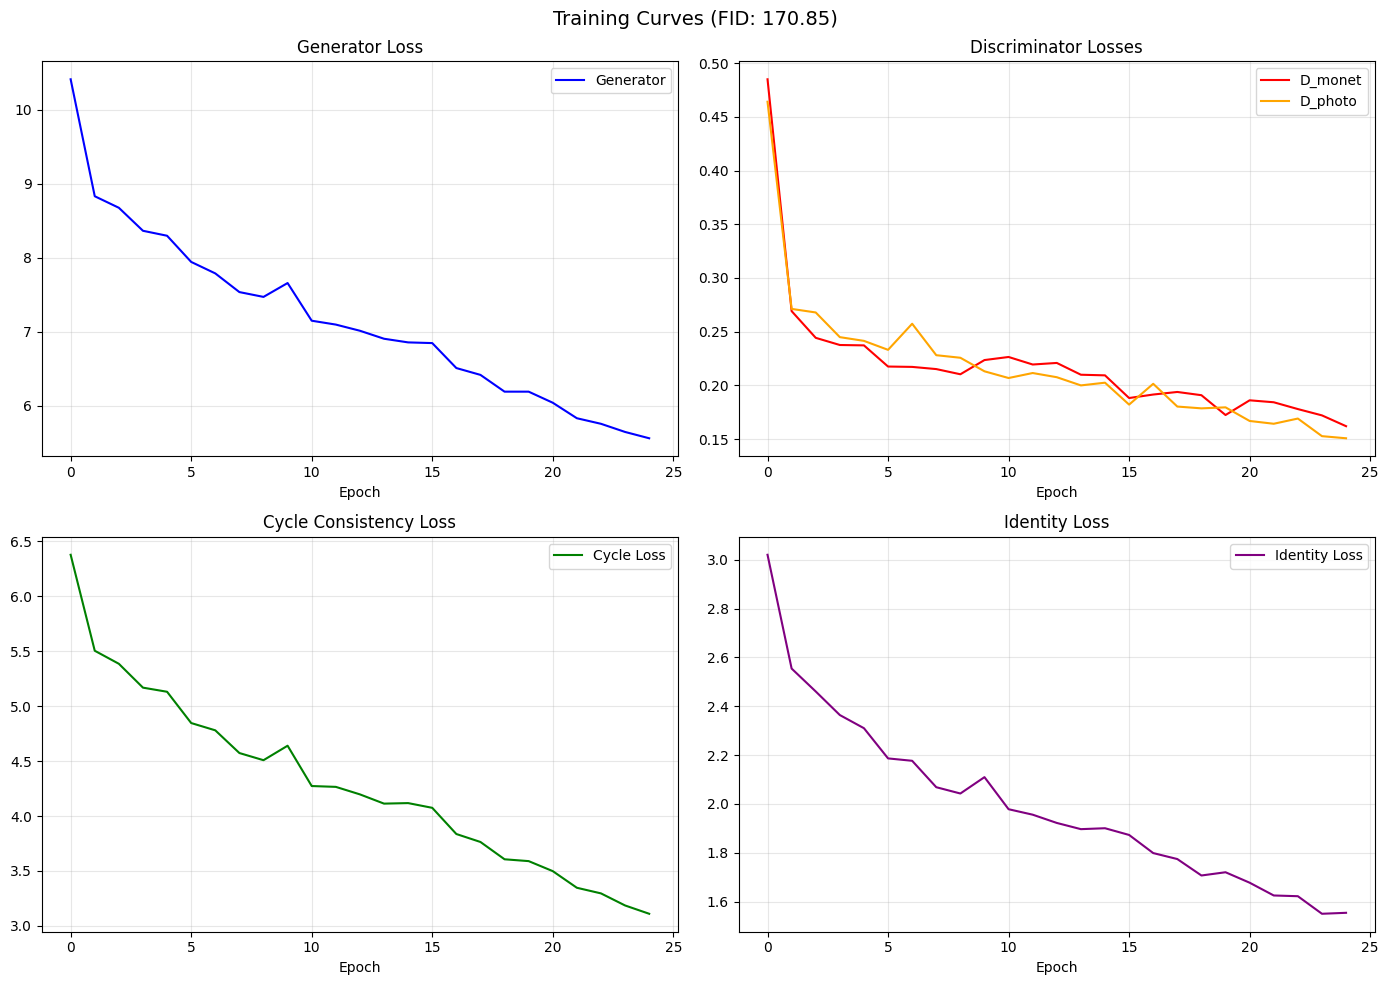

In [18]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(history['G'], label='Generator', color='blue')
axes[0, 0].set_title('Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['D_monet'], label='D_monet', color='red')
axes[0, 1].plot(history['D_photo'], label='D_photo', color='orange')
axes[0, 1].set_title('Discriminator Losses')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history['cycle'], label='Cycle Loss', color='green')
axes[1, 0].set_title('Cycle Consistency Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history['identity'], label='Identity Loss', color='purple')
axes[1, 1].set_title('Identity Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Training Curves (FID: {fid_score:.2f})', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

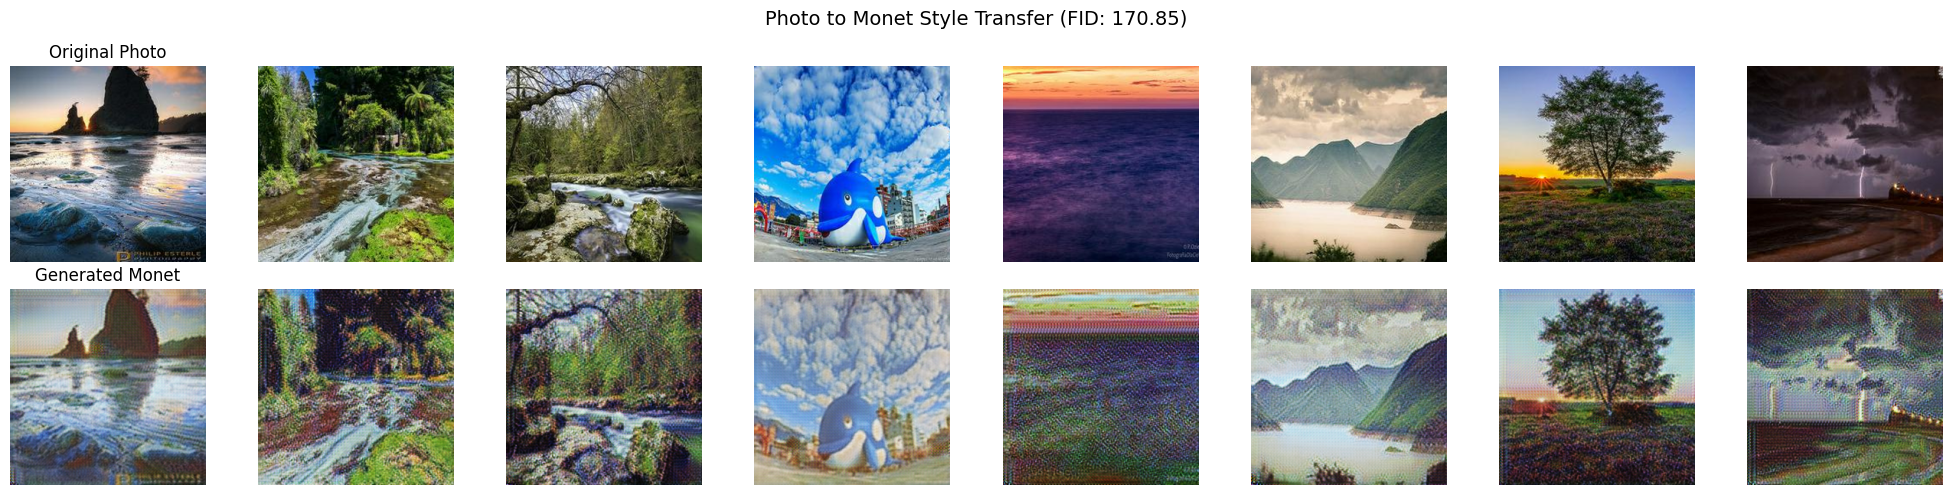

In [19]:
# Show generated samples
def show_translation_results(generator, num_samples=8):
    generator.eval()
    photos = next(iter(DataLoader(photo_dataset, batch_size=num_samples, shuffle=True)))
    
    with torch.no_grad():
        fake_monets = generator(photos.to(cfg.DEVICE))
    
    photos = photos * 0.5 + 0.5
    fake_monets = fake_monets * 0.5 + 0.5
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2.5, 5))
    
    for i in range(num_samples):
        axes[0, i].imshow(photos[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original Photo', fontsize=12)
        
        axes[1, i].imshow(fake_monets[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Generated Monet', fontsize=12)
    
    plt.suptitle(f'Photo to Monet Style Transfer (FID: {fid_score:.2f})', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(cfg.OUTPUT_DIR, 'translation_results.png'), dpi=150)
    plt.show()

show_translation_results(G_monet)

## 9. Summary

In [20]:
print("\n" + "=" * 60)
print("           CYCLEGAN TRAINING SUMMARY")
print("=" * 60)
print(f"\nArchitecture:")
print(f"  - Generator: ResNet-{cfg.N_RESIDUAL} ({cfg.NGF} base filters)")
print(f"  - Discriminator: 70x70 PatchGAN ({cfg.NDF} base filters)")
print(f"  - Image Size: {cfg.IMAGE_SIZE}x{cfg.IMAGE_SIZE}")
print(f"\nTraining:")
print(f"  - Epochs: {cfg.EPOCHS}")
print(f"  - Batch Size: {cfg.BATCH_SIZE}")
print(f"  - Learning Rate: {cfg.LR}")
print(f"  - Lambda Cycle: {cfg.LAMBDA_CYCLE}")
print(f"  - Lambda Identity: {cfg.LAMBDA_IDENTITY}")
print(f"  - Training Time: {total_time:.2f} minutes")
print(f"\n" + "+" * 60)
print(f"       FID SCORE: {fid_score:.2f}")
print("+" * 60)


           CYCLEGAN TRAINING SUMMARY

Architecture:
  - Generator: ResNet-9 (64 base filters)
  - Discriminator: 70x70 PatchGAN (64 base filters)
  - Image Size: 256x256

Training:
  - Epochs: 25
  - Batch Size: 1
  - Learning Rate: 0.0002
  - Lambda Cycle: 10.0
  - Lambda Identity: 5.0
  - Training Time: 81.47 minutes

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
       FID SCORE: 170.85
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
